# Transfer Learning

Transfer learning is, in essence, the application of a neural net trained on one task to a new task. Because convolutional neural nets are almost exclusively used to examine visual data, they are particularly good at transfer learning. 

A network trained to recognize dogs and cats in photographs will learn some features that are universal to processing photographs, and so it may be a good starting point for a network that detects frogs and birds in photographs. A network trained to detect cancer in radiographs will learn some things that are universal to processing radiographs, and so might be a good starting point for a network that detects foregin bodies, or bone fractures. 

In this lab we'll use transfer learning to re-train a neural network to perform a new task. 

In [1]:
# this should look familiar from the previous labs. 
# We could choose any of the pre-built nets here instead. 
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, image as keras_image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# This is a new built in dataset that we haven't seen before.
# It is 60,000 (50k training, 10k test) small (32x32) RGB images 
# classified into 100 classes:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Some global factors that will be kept constant. 
batch_size = 32
num_classes = 100
image_size = 96
epochs = 5

# FOR DISPLAY PURPOSES
unprocessed_training_images = x_train
unprocessed_training_labels = y_train

# Because the network we're fine-tuning (MobileNetV2) has several pooling layers
# the smallest image it can process is 96x96, these images are 32x32. To fix this
# we are manually rescaling all the images using scipy. We are also applying the 
# MobileNetV2 preprocess_input function here. 
def adjust_input_image(rgb_data):
    adjusted = preprocess_input(rgb_data)
    
    # Scales width and height by 3, leaves color channels at original scale
    adjusted = ndimage.zoom(adjusted, (3, 3, 1), order=0)

    return adjusted

x_train = np.array([adjust_input_image(x) for x in x_train])
x_test = np.array([adjust_input_image(x) for x in x_test])

# And we still need to one-hot encode the labels as usual
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


# This isn't required for the cifar dataset, but it might be worth talking about...

# # Finally, in order to speed up training, because our dataset is large and 
# # so is our network, we're going to use a generator and model.fit_generator
# # We could also use this class to apply a lot of data augmentation on the fly
# # which can improve results, and is very convienent. 
# train_datagen = ImageDataGenerator(validation_split=0.2)
# train_datagen.fit(x_train)

# # Because of the way the generators work, we have to do
# # extra work to get a validation set. 
# train_generator = train_datagen.flow(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     subset='training')

# validation_generator = train_datagen.flow(
#     x_train,
#     y_train,
#     batch_size=batch_size,
#     subset='validation')

Using TensorFlow backend.


We can see that the preprocessing function changes the pixel values by scaling some of them between -1 and 1, this is not nessesarally typical, and if we use matplotlibs imshow on the preprocessed image-set, it will sometimes look a little funky as a result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


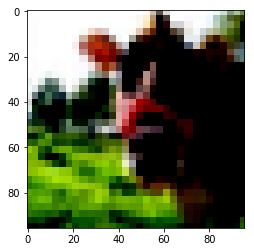

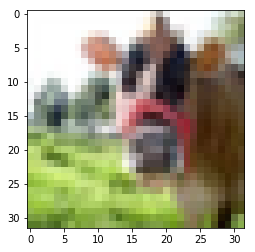

In [2]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(unprocessed_training_images[0])
plt.show()

Lets also take alook at a few of the examples from cifar100. This is a challenging dataset, the images are small and therefore low resolution, and some are pretty obscure—the 'cloud' and two 'sea' images below lack detail. The 'aquarium fish' and 'rose' and 'squirrel' are tough as well. 

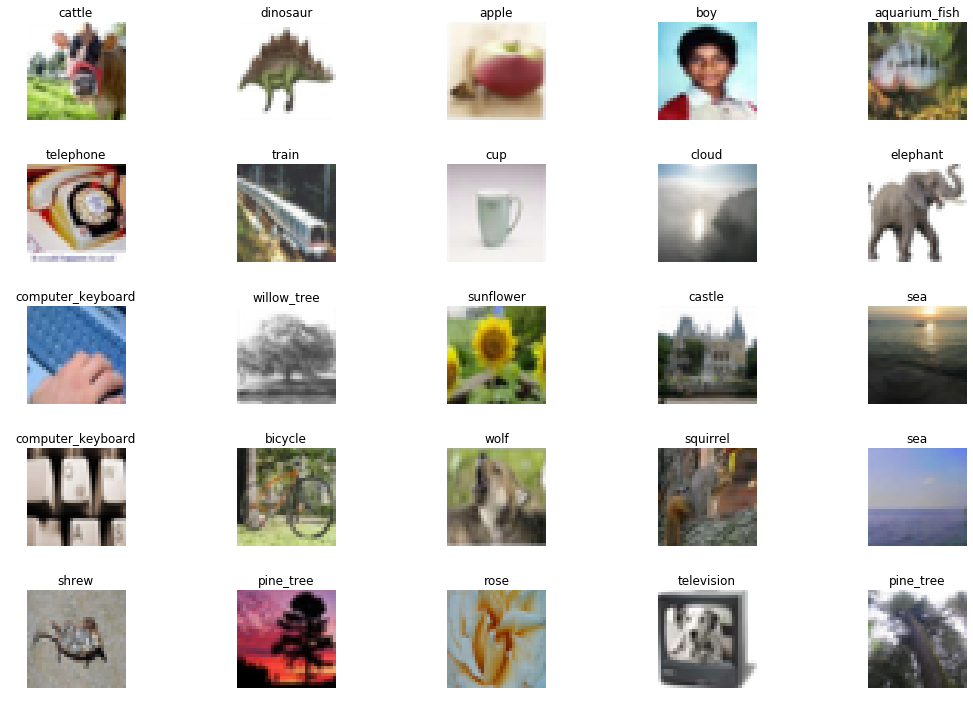

In [3]:
# Some of these are genuinely challenging... 
label_map = [
    'apple', # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm'
]

plt.figure(figsize=(15, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    ax.axis('off')
    ax.set_title(label_map[unprocessed_training_labels[i][0]])
    plt.imshow(unprocessed_training_images[i])

plt.tight_layout()
plt.show()

In [4]:
# This should look familiar from previous labs.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

Lets quickly loook a little closer at MobileNetV2, so we can think carefully about which layers to freeze and how to apply transfer learning. 

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Layers go from 0-154
#   initial=0-9
#   block1 = 10-18
#   block2 = 19-27
#   block3 = 28-36
#   block4 = 37-45
#   block5 = 46-54
#   block6 = 55-63
#.  block7 = 64-72
#   block8 = 73-81
#.  block9 = 81-90
#   block10= 91-98
#   block11= 99-107
#.  block12= 108-116
#.  block13= 117-125
#   block14= 126-134
#.  block15= 135-143
#.  block16= 144-151
#.  final_conv = 152, 
#   conv_bn 153
#   out_relu = 154
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
_____________________________________

# Transfer Learning Tips and Pitfalls

One of the challenges with the Cifar100 dataset is that the images are very small. Roughly 10x smaller than the images that MobileNetV2 was originally trained on. This means 1) there is just less input information, and if we look at some of the Cifar images I'm sure you'll agree that some are quite difficult to identify, even for us humans and 2) the kernals that extracted useful information from larger images might not apply as well to smaller ones. 

Additionally, different hyperparameters can dramatically impact the effectiveness of transfer learning. Some combinations will be very effective, others will lead to overfitting, others won't learn anything at all. With transfer learning it is important to consider the similarity of the task being trained, as well as the amount of data available. 

If we have a small amount of data, we'll be more likely to overfit during training. If the task is significantly different than the task the original net trained on, the learned kernels may not extract information that is useful for the new task. 

In [26]:
# The first way we'll do transfer learning REALLY saves time, but
# only works if you don't want to fine tune any of the layers 
# from the original network. What we can do instead is memorize
# the output of the base network, since it won't be changing,
# and then repeatedly train on those outputs and the training labels

# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Unlike before, we're going to just run the images through this base layer once
# This takes awhile, we're essentially doing a round of evaluation on both datasets.
# And we'll save them incase we want to experiment with different models to transfer
# on top of these.
training_features = base_model.predict(x_train)
np.savez('MobileNetV2_features_train', features=training_features)

test_features = base_model.predict(x_test)
np.savez('MobileNetV2_features_test', features=test_features)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


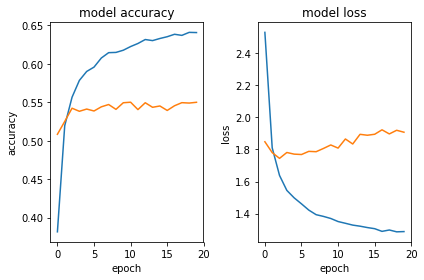

Test loss: 1.88
Test accuracy: 0.557


In [6]:
# If you have not run the above cell during this session, uncomment these lines to load the features.
# training_features = np.load('MobileNetV2_features_train.npz')['features']
# test_features = np.load('MobileNetV2_features_test.npz')['features']

# Also unlike before, we're going to build a complete model
# in the normal way, but define the input shape based on the 
# features predicted by base_model!
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=training_features.shape[1:]))
model.add(Dropout(rate=0.3))
model.add(Dense(units=100, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_features, y_train, batch_size=batch_size, epochs=20, validation_split=0.2, verbose=False)

plot_training_history(history, model)
loss, accuracy = model.evaluate(test_features, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

It's worth noting that cifar100 is a very tricky dataset. The images are small, 100 classes is several, and 100 classes amongst rougly 60k examples is only on average 600 samples per class. In fact 28% would have put us in the top 20 on a semi-recent Kaggle competition, and 50% in the top ten: 

https://www.kaggle.com/c/ml2016-7-cifar-100/leaderboard

Boom, we're a top ten Kaggel competitor just like that. Though, looking at validation accuracy and loss, it's not clear we're going to improve much further. It may be worth trying to do transfer learning from a different pre-trained model.

# Ignoring Some Layers and Fine Tuning

We can use the same idea, but allow some of the layers of the original network to retrain as well. For example, MobileNetV2 is split into 16 blocks. If we think the final few convolutional layers are too specific to the task our original net was trained on (the ImageNet dataset in this case) then we can chop off some of these blocks and get the trained features from an earlier block, and use THOSE as our training_features. Furthermore, in our new model we can have the same convoluitonal layers as the original mode, and train those. This is called fine-tuning.

Unfortunately, doing this the way we have done above is very hard in Keras, especially with merge layers which MobileNetV2 has. Instead, we have to "freeze" the layers by setting them to be untrainable manually, then "train" the entire network with some layers of the layers frozen, especially the early ones. This is a significant perfomance penalty because we have to recompute the output of all the frozen layers each time, instead of simply memorizing it. 

The alternative is to manually construct a model that matches the architecture we're seeking, which can be challenging for the more complex architectures. 

In [20]:
# One way to do transfer learning is called "fine tuning". This is where you take an existing network
# and freeze some of the layers. In addition to freezing some layers, you'll have to add at a minimum
# a new output layer that matches the number of classes for the new task. 

# Typically the earlier layers are frozen, because these are likely to have learned universal/simple features.
# The later layers have learned combinations of those features and are increasingly specific to the task
# that the network was trained for. 

def transfer_from_mobilenet(optimizer, freeze_first_n_layers):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

    old_top = base_model.output
    old_top = GlobalAveragePooling2D()(old_top)
    old_top = Dropout(rate=0.2)(old_top)
    new_top = Dense(num_classes, activation='softmax')(old_top)
    
    model = Model(inputs=base_model.input, outputs=new_top)

    for layer in model.layers[:freeze_first_n_layers]:
        layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=True)
    
    return history, model

Transfer learning with sgd, 134 Will save as:  sgd_134

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 448s 11ms/step - loss: 2.1321 - acc: 0.4610 - val_loss: 3.1606 - val_acc: 0.2702
Epoch 2/5
40000/40000 [==============================] - 437s 11ms/step - loss: 1.2861 - acc: 0.6355 - val_loss: 3.2792 - val_acc: 0.2776
Epoch 3/5
40000/40000 [==============================] - 481s 12ms/step - loss: 1.0326 - acc: 0.7010 - val_loss: 3.1538 - val_acc: 0.2896
Epoch 4/5
40000/40000 [==============================] - 442s 11ms/step - loss: 0.8609 - acc: 0.7463 - val_loss: 3.4080 - val_acc: 0.2779
Epoch 5/5
40000/40000 [==============================] - 436s 11ms/step - loss: 0.7288 - acc: 0.7820 - val_loss: 3.4058 - val_acc: 0.2807


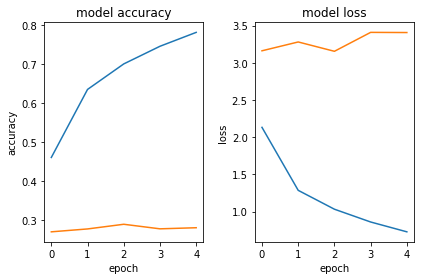

10000/10000 [==============================] - 93s 9ms/step
Test loss: 3.42
Test accuracy: 0.285
Transfer learning with sgd, 143 Will save as:  sgd_143

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 423s 11ms/step - loss: 2.2254 - acc: 0.4397 - val_loss: 3.5544 - val_acc: 0.2384
Epoch 2/5
40000/40000 [==============================] - 419s 10ms/step - loss: 1.3883 - acc: 0.6130 - val_loss: 3.2658 - val_acc: 0.2676
Epoch 3/5
40000/40000 [==============================] - 420s 11ms/step - loss: 1.1657 - acc: 0.6670 - val_loss: 3.3100 - val_acc: 0.2757
Epoch 4/5
40000/40000 [==============================] - 412s 10ms/step - loss: 1.0249 - acc: 0.7046 - val_loss: 3.4840 - val_acc: 0.2758
Epoch 5/5
40000/40000 [==============================] - 412s 10ms/step - loss: 0.9124 - acc: 0.7313 - val_loss: 3.4236 - val_acc: 0.2837


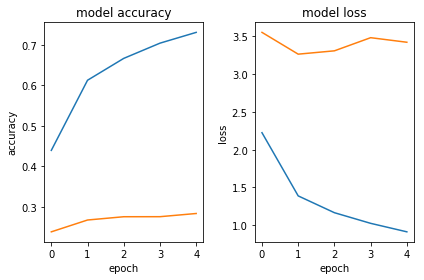

10000/10000 [==============================] - 94s 9ms/step
Test loss: 3.42
Test accuracy: 0.279
Transfer learning with <keras.optimizers.Adam object at 0x1789a7a90>, 134 Will save as:  <keras.optimizers.Adam object at 0x1789a7a90>_134

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 452s 11ms/step - loss: 2.2795 - acc: 0.4314 - val_loss: 3.1332 - val_acc: 0.2745
Epoch 2/5
40000/40000 [==============================] - 444s 11ms/step - loss: 1.3246 - acc: 0.6299 - val_loss: 3.0467 - val_acc: 0.3046
Epoch 3/5
40000/40000 [==============================] - 444s 11ms/step - loss: 1.0659 - acc: 0.6914 - val_loss: 3.1948 - val_acc: 0.3015
Epoch 4/5
40000/40000 [==============================] - 443s 11ms/step - loss: 0.8707 - acc: 0.7451 - val_loss: 3.2536 - val_acc: 0.2991
Epoch 5/5
40000/40000 [==============================] - 442s 11ms/step - loss: 0.7204 - acc: 0.7863 - val_loss: 3.5583 - val_acc: 0.2631


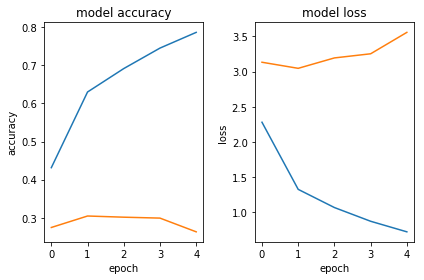

10000/10000 [==============================] - 95s 10ms/step
Test loss: 3.54
Test accuracy: 0.265
Transfer learning with <keras.optimizers.Adam object at 0x1789a7a90>, 143 Will save as:  <keras.optimizers.Adam object at 0x1789a7a90>_143

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 479s 12ms/step - loss: 1.8946 - acc: 0.5027 - val_loss: 3.4321 - val_acc: 0.2499
Epoch 2/5
40000/40000 [==============================] - 461s 12ms/step - loss: 1.2517 - acc: 0.6451 - val_loss: 3.1929 - val_acc: 0.2778
Epoch 3/5
40000/40000 [==============================] - 442s 11ms/step - loss: 1.0715 - acc: 0.6919 - val_loss: 3.3809 - val_acc: 0.2727
Epoch 4/5
40000/40000 [==============================] - 469s 12ms/step - loss: 0.9395 - acc: 0.7274 - val_loss: 3.4698 - val_acc: 0.2762
Epoch 5/5
40000/40000 [==============================] - 423s 11ms/step - loss: 0.8400 - acc: 0.7531 - val_loss: 3.5608 - val_acc: 0.2742


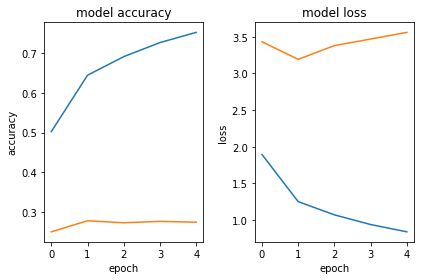

10000/10000 [==============================] - 95s 10ms/step
Test loss: 3.55
Test accuracy: 0.275


In [21]:
from itertools import product
from keras.optimizers import Adam

# These experiments took *several hours* to run originally.
# Saving the model after an experiment is a good idea, then you
# can experiment further with promising models, without rerunning
# entier experiments.
save_directory = 'saved_models/'

# More agressive optimizers like adam can result in overfitting
# We should watch for that in our results.
optimizers = [
    'sgd',
    Adam(lr=0.0001)  # Slower than normal learning rate. 
]

# Note: experimentally freezing only the first 2 blocks
# resulted in much slower performance, though for SGD freezing 
# only the first block did achieve 50% accuracy on test data 
freeze_layer_counts = [
    134,   # Up through block 14 frozen
    143    # Up through block 15 frozen
    
    # If we were to set a value here to 154, it would freeze all the original layers
    # which can be quite successful, but we can make training much faster using a 
    # different tactic to freeze all the original layers as demonstrated above
]



# This takes a LOOOOONNNNNNNGGGGG time, don't re-run it unless you're prepared to wait. 
# We are grid searching over 48 parameter combinations.
for optimizer, freeze_first_n_layers in product(optimizers, freeze_layer_counts):
    saved_name = f'{optimizer}_{freeze_first_n_layers}'
    print(f'Transfer learning with {optimizer}, {freeze_first_n_layers}', "Will save as: ", saved_name)
    print()

    history, model = transfer_from_mobilenet(optimizer, freeze_first_n_layers)
    model.save(save_directory + saved_name)
    plot_training_history(history, model)
    
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 416s 10ms/step - loss: 2.0448 - acc: 0.4860 - val_loss: 3.8341 - val_acc: 0.2526
Epoch 2/5
40000/40000 [==============================] - 403s 10ms/step - loss: 1.3913 - acc: 0.6119 - val_loss: 3.8005 - val_acc: 0.2776
Epoch 3/5
40000/40000 [==============================] - 402s 10ms/step - loss: 1.1898 - acc: 0.6610 - val_loss: 3.9371 - val_acc: 0.2614
Epoch 4/5
40000/40000 [==============================] - 412s 10ms/step - loss: 1.0485 - acc: 0.6911 - val_loss: 3.7360 - val_acc: 0.2893
Epoch 5/5
40000/40000 [==============================] - 407s 10ms/step - loss: 0.9416 - acc: 0.7200 - val_loss: 3.8824 - val_acc: 0.2782


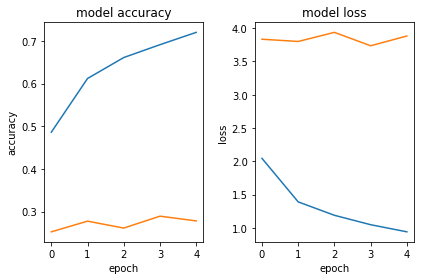

Test loss: 3.87
Test accuracy: 0.274


In [22]:
history, model = transfer_from_mobilenet('adam', 151) # Leave the final 2 conv layers alone, freeze all the bottleneck blocks
model.save(save_directory + saved_name)
plot_training_history(history, model)

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Loaded model: [(512, 0.2), (256, 0.2)]_sgd_134
Epoch 1/5
1250/1250 [==============================] - 528s 422ms/step - loss: 1.4045 - acc: 0.6111 - val_loss: 3.1844 - val_acc: 0.2867
Epoch 2/5
1250/1250 [==============================] - 509s 408ms/step - loss: 1.2417 - acc: 0.6492 - val_loss: 3.3089 - val_acc: 0.2777
Epoch 3/5
1250/1250 [==============================] - 534s 427ms/step - loss: 1.0827 - acc: 0.6897 - val_loss: 3.7630 - val_acc: 0.2576
Epoch 4/5
1250/1250 [==============================] - 529s 423ms/step - loss: 0.9698 - acc: 0.7186 - val_loss: 3.5856 - val_acc: 0.2605
Epoch 5/5
1250/1250 [==============================] - 490s 392ms/step - loss: 0.8744 - acc: 0.7416 - val_loss: 3.5673 - val_acc: 0.2765


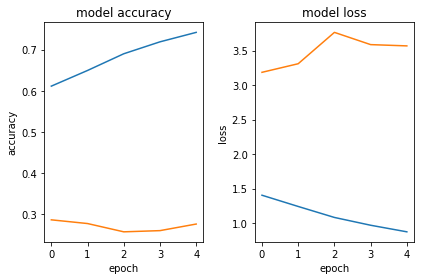

Test loss: 4.05
Test accuracy: 0.219
Loaded model: [(512, 0.2), (256, 0.2)]_adam_154
Epoch 1/5
1250/1250 [==============================] - 450s 360ms/step - loss: 1.7408 - acc: 0.5351 - val_loss: 3.4016 - val_acc: 0.2405
Epoch 2/5
1250/1250 [==============================] - 429s 343ms/step - loss: 1.6753 - acc: 0.5509 - val_loss: 3.5947 - val_acc: 0.2156
Epoch 3/5
1250/1250 [==============================] - 431s 345ms/step - loss: 1.5785 - acc: 0.5720 - val_loss: 3.7346 - val_acc: 0.2138
Epoch 4/5
1250/1250 [==============================] - 429s 343ms/step - loss: 1.5394 - acc: 0.5810 - val_loss: 3.7741 - val_acc: 0.2180
Epoch 5/5
1250/1250 [==============================] - 432s 346ms/step - loss: 1.4794 - acc: 0.5943 - val_loss: 3.7559 - val_acc: 0.2240


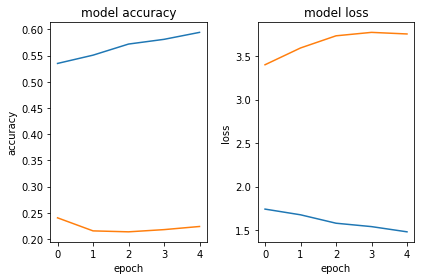

Test loss: 3.36
Test accuracy: 0.188


KeyboardInterrupt: 

In [21]:
from keras.models import load_model

promising_models = [
    '' # ... TODO
]

for model_name in promising_models:
    model = load_model(save_directory + model_name)
    print(f'Loaded model: {model_name}')
    
    # Everything about the model was saved, so we don't need to recompile
    # or anything like that, we can just start fitting again:
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = validation_generator, 
        validation_steps = len(validation_generator),
        epochs = 5, 
        verbose=True
    )
    
    model.save(save_directory + model_name + '_additional_training')
    plot_training_history(history, model)
    
    # Lets look at the test scores on these.
    loss, accuracy = model.evaluate_generator(data_generator.flow(x_test, y_test), verbose=False, steps=1)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [32]:
# TODO: decide if this is worth it... we can just stretch the images using Keras built in
# functions and it'll probably be fine. 

# Instead, of these images, lets try a dataset somewhat closer to the ImageNet dataset. 
# The dataset is too large to reasonably redistribute as part of this repository, so you will
# have to download it separately.
# The dataset can be found here: 
# https://www.kaggle.com/alxmamaev/flowers-recognition/

# When you've downloaded and unzipped the images, set the following variable to
# path to the directory labeled 'flowers' then run this code to preprocess all
# the images to be square and padded. This only has to happen once. 
# flower_dataset_directory = 'flowers_dataset/flowers/'
# resized_flowers_location = 'flowers_dataset/resized/'

# if not os.path.exists(resized_flowers_location): 
#     os.mkdir(resized_flowers_location)

# # This code should look familar from the previous lab:
# from PIL import Image, ImageOps
# import os

# def resize_and_pad_image(input_image_path):
#     image = Image.open(input_image_path)
#     width, height = image.size
    
#     w_pad = 0
#     h_pad = 0
#     bonus_h_pad = 0
#     bonus_w_pad = 0
#     if width > height:
#         pix_diff = (width - height)
#         h_pad = pix_diff // 2
#         bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
#     elif height > width:
#         pix_diff = (height - width)
#         w_pad = pix_diff // 2
#         bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
#     # else: image is already square. Both pads stay 0
    
#     image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
#     return image
#     # Save for display as well as to use Keras preprocessing later


# flower_folders = ['daisy/', 'dandelion/', 'rose/', 'sunflower/', 'tulip/']
# for flower_type in flower_folders:
#     input_path = flower_dataset_directory + flower_type
#     if not os.path.exists(resized_flowers_location + flower_type): 
#         os.mkdir(resized_flowers_location + flower_type)
    
#     for image_name in os.listdir(input_path):
#         if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
#         try:
#             image = resize_and_pad_image(input_path + image_name)
#             image.save(resized_flowers_location + flower_type + image_name)
#         except:
#             # If an image cannot be processed for some reason, just leave it out
#             # of our final dataset.
#             continue


Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Epoch 1/1
3462/3462 [==============================] - 119s 34ms/step - loss: 1.8441 - acc: 0.2054 - val_loss: 2.3820 - val_acc: 0.1777
Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Epoch 1/1
3462/3462 [==============================] - 108s 31ms/step - loss: 1.8188 - acc: 0.2299 - val_loss: 2.4948 - val_acc: 0.1777
Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Epoch 1/1
3462/3462 [==============================] - 107s 31ms/step - loss: 1.7975 - acc: 0.2334 - val_loss: 2.3621 - val_acc: 0.1812
Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Epoch 1/1
3462/3462 [==============================] - 106s 31ms/step - loss: 1.7748 - acc: 0.2545 - val_loss: 2.0962 - val_acc: 0.2439
Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Epoch 1/1
3462/3462 [====================

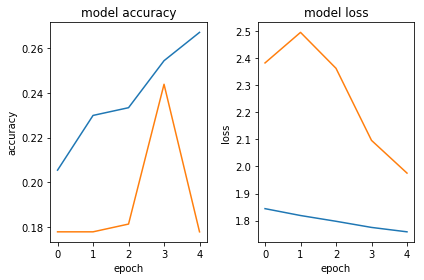

In [47]:
# TODO: Probably delete this.

# Instead, of these images, lets try a dataset somewhat closer to the ImageNet dataset. 
# The dataset is too large to reasonably redistribute as part of this repository, so you will
# have to download it separately.

# The dataset can be found here: 
# https://www.kaggle.com/alxmamaev/flowers-recognition/
flower_dataset_directory = 'flowers_dataset/flowers/'

# Load the images by class
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Bigger takes longer, but can be mroe accurate.
# 96x96 is the smallest allowed shape for MobileNetV2
image_size = 96
batch_size = 8
num_epochs = 30

# Same as above, import the pretrained model
# But this time we've got bigger images, so we'll use MobileNetV2's default shape
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
old_top = base_model.output
old_top = GlobalAveragePooling2D()(old_top)
new_top = Dense(len(classes), activation='softmax')(old_top)
model = Model(inputs=base_model.input, outputs=new_top)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## We're doing a little bit of a hack to employ cross validation.
## Because we don't have an excellently curated dataset we want the validation
## data to change each training round.
historical_data = {
    'acc': [],
    'val_acc': [],
    'loss': [],
    'val_loss': []
}

for _ in range(num_epochs):
    # Prepare the data and apply some common augmentation
    # Plus, use 20% as validation data randomly each time.
    train_datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input,
        validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(
        flower_dataset_directory,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=classes,
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        flower_dataset_directory,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        classes=classes,
        subset='validation')
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = 1)
    
    historical_data['acc'].append(history.history['acc'])
    historical_data['val_acc'].append(history.history['val_acc'])
    historical_data['loss'].append(history.history['loss'])
    historical_data['val_loss'].append(history.history['val_loss'])

figure = plt.figure()

plt.subplot(1, 2, 1)
plt.plot(historical_data['acc'])
plt.plot(historical_data['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(historical_data['loss'])
plt.plot(historical_data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

figure.tight_layout()
plt.show()

Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.
Learning Rate: 1e-06
Unfrozen Layers: 3
Epoch 1/3
216/216 [==============================] - 114s 529ms/step - loss: 0.9064 - acc: 0.6542 - val_loss: 2.2246 - val_acc: 0.1769
Epoch 2/3
216/216 [==============================] - 51s 238ms/step - loss: 0.6868 - acc: 0.7420 - val_loss: 2.5760 - val_acc: 0.2320
Epoch 3/3
216/216 [==============================] - 51s 236ms/step - loss: 0.6413 - acc: 0.7534 - val_loss: 2.4613 - val_acc: 0.2296


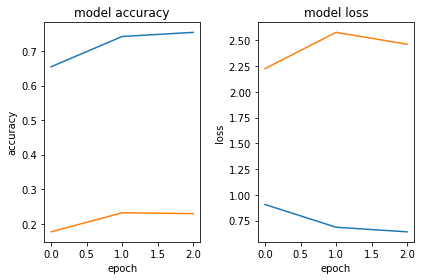

In [83]:
# TODO: Can probably delete this as well... 

from itertools import product
from keras.optimizers import SGD, Adam

# Bigger takes longer, but can be mroe accurate.
# 96x96 is the smallest allowed shape for MobileNetV2
image_size = 96
batch_size = 16
num_epochs = 3

# Prepare the data and apply some common augmentation
# Plus, use 20% as validation data randomly each time.
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    flower_dataset_directory,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    flower_dataset_directory,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,
    subset='validation')

last_n_layers = [3]
# last_n_layers = [50, 20, 4]
# learning_rates = [.0001, .00001, .000001]
# for last_n_layer, learning_rate in product(last_n_layers, learning_rates):
for last_n_layer in last_n_layers:
    print(f'Learning Rate: {learning_rate}\nUnfrozen Layers: {last_n_layer}')
    # Same as above, import the pretrained model 
    # But this time we've got bigger images, so we'll use MobileNetV2's default shape
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    old_top = base_model.output
    old_top = GlobalAveragePooling2D()(old_top)
    old_top = Dense(128, activation='relu')(old_top)
    old_top = Dense(32, activation='relu')(old_top)
    new_top = Dense(len(classes), activation='softmax')(old_top)
    model = Model(inputs=base_model.input, outputs=new_top)

    for i, layer in enumerate(model.layers):
        layer.trainable = len(model.layers) - i <= last_n_layer

    model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = num_epochs, 
        verbose=True
    )

    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

In [81]:
# From last lab
import cv2
import matplotlib.image as mpimg
from keras import backend as K

def cam(image_path, model, desired_shape, preprocess_input, decode_predictions, final_conv_idx):
    # This should look familiar from the above.
    # We're just loading the image and getting our networks prediction 
    image = keras_image.load_img(image_path, target_size=desired_shape)
    input_data = keras_image.img_to_array(image)
    input_data = np.expand_dims(input_data, axis=0)
    input_data = preprocess_input(input_data)
    
    # Use the model to make a prediction so we can label the image later.
    preds = model.predict(input_data)
    
    # We also get the output values for the final layer related to the top prediction. 
    top_prediction = np.argmax(preds[0])
    output = model.output[:, top_prediction]
    
    # We have to fetch the results of the final convolutional layer
    # Because the graidents of that layer will tell us which pixels
    # Contributed most to our models decision
    
    # TODO: THIS MIGHT BE WRONG, THERE ARE MULTIPLE LAYERS NAMED Conv_1
#     last_conv_layer = model.get_layer(final_conv_name)
    last_conv_layer = model.layers[final_conv_idx]

    # And now we want to get the mean gradient intensity of 
    # all the filters in that layer. We use 'output' here to 
    # compute the gradient for the output associated with the 
    # top prediction. 
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This essentially creates a function that acts as a model, but where
    # it's easier to get the values out that we want. 
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([input_data])
    
    # Using the avg gradient and the last conv layer's output
    # calculate the weight of each pixel's contribution. 
    for i, pooled_gradient_value in enumerate(pooled_grads_value):
        conv_layer_output_value[:, :, i] *= pooled_gradient_value
    
    # Build the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Load the image with openCV
    img = cv2.imread(image_path)

    # Resize the heatmap, since the final conv layer isn't the same size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Move to RGB values as ints 0-255 instead of floats 0-1
    heatmap = np.uint8(255 * heatmap)
    
    # Build the heatmap numerically
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    
    # Save it, hilariously, so that we can show it with matplotlib
    output = 'heatmaps/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img = mpimg.imread(output)

    # Show it.
    plt.imshow(img)
    plt.axis('off')
    print(classes[np.argmax(preds)])
    plt.show()

daisy


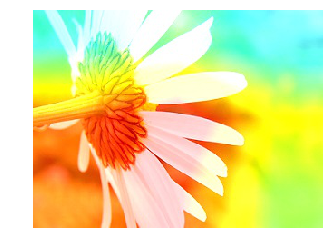

daisy


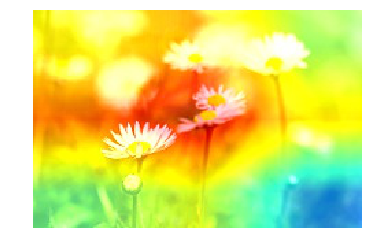

daisy


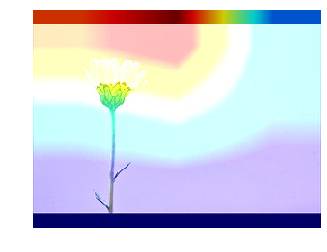

daisy


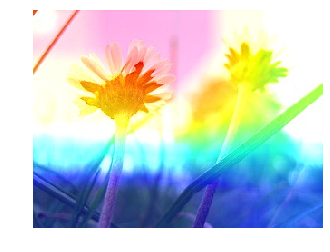

daisy


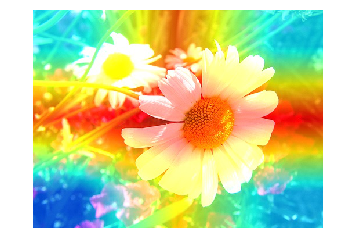

daisy


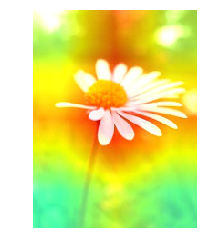

KeyboardInterrupt: 

In [84]:
for file in os.listdir(flower_dataset_directory + 'daisy/'):
    image_path = flower_dataset_directory + 'daisy/' + file
    cam(image_path, model, (96, 96), preprocess_input, decode_predictions, 152)